<a href="https://colab.research.google.com/github/madeyemocki/xai_fnd_data/blob/main/Data_cleaning_laymen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import json
import pandas as pd
import requests
import io
from urllib.request import urlopen
import json
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
from pprint import pprint


In [98]:
# load JSON
def load_data(filename):
    df = pd.read_json(filename)
    data_sorted = df['formAnswers'].apply(pd.Series).join(df[['swymerId', 'workDurationInSeconds']])
    return data_sorted.fillna("")

In [99]:
# from google.colab import files

# uploaded = files.upload()
#load json files
v1_q = load_data('data/answers-v1-basic-group-2-qualification.json')
v1_m = load_data('data/answers-v1-basic-group-2-main.json')

v2_q = load_data('data/answers-v2-salient-group-2-qualification.json')
v2_m = load_data('data/answers-v2-salient-group-2-main.json')

#todo v3 and journos

In [100]:
#convert to pandas data frame
df_v1_q = pd.DataFrame(v1_q)
df_v1_m = pd.DataFrame(v1_m)

df_v2_q = pd.DataFrame(v2_q)
df_v2_m = pd.DataFrame(v2_m)

In [101]:
# remove columns from df_XX_q which are redundant or not needed for the analysis
reduntant_columns = [
  "METADATA.FEATURE",
  "METADATA.GROUP",
  "confirm.0",
]

df_v1_q = df_v1_q.drop(columns=reduntant_columns)
df_v2_q = df_v2_q.drop(columns=reduntant_columns)

# get a list of all column names starting with "tutorial."
tutorial_columns = [col for col in df_v1_q.columns if col.startswith("tutorial.")]
tutorial_columns.append("understand-task")

# remove tutorial columns from both dataframes
df_v1_q = df_v1_q.drop(columns=tutorial_columns)
df_v1_m = df_v1_m.drop(columns=tutorial_columns)

df_v2_q = df_v2_q.drop(columns=tutorial_columns)
df_v2_m = df_v2_m.drop(columns=tutorial_columns)

# remove "METADATA.PART" columns from both dataframes
#todo v3
df_v1_q = df_v1_q.drop(columns=["METADATA.PART"])
df_v1_m = df_v1_m.drop(columns=["METADATA.PART"])

df_v2_q = df_v2_q.drop(columns=["METADATA.PART"])
df_v2_m = df_v2_m.drop(columns=["METADATA.PART"])

In [102]:
# merge df_v1_q and df_v1_m on swymerId, 
# only keep rows where aliasId is in both dataframes (inner join)
# keep all columns from both and suffix them with .qualification and .main (e.g. for POINTS)
df_v1 = pd.merge(df_v1_q, df_v1_m, on='swymerId', how='inner', suffixes=('.qualification', '.main'))

In [103]:
# merge df_v2_q and df_v2_m on swymerId, 
# only keep rows where aliasId is in both dataframes (inner join)
# keep all columns from both and suffix them with .qualification and .main (e.g. for POINTS)
df_v2 = pd.merge(df_v2_q, df_v2_m, on='swymerId', how='inner', suffixes=('.qualification', '.main'))

In [104]:
#todo v3

columns = list(df_v1.columns)
pprint(columns)

['information-literacy.identify-misinformation',
 'information-seeking.sources.online-newspaper',
 'expectations.sceptical-about-ai',
 'information-seeking.sources.personal-social-networks',
 'personal-code',
 'information-literacy.efficiently-use-subscribed-and-openaccess',
 'information-seeking.purpose.keep-up-to-date',
 'POINTS.qualification',
 'information-seeking.truthfulness.facebook',
 'information-seeking.purpose.general-awareness',
 'expectations.benefit-of-doubt',
 'expectations.trust-new-tech',
 'newsitem.10.rating-before-xai',
 'newsitem.10.control-question',
 'information-seeking.access.library',
 'information-seeking.top-source-seriousness',
 'journalist',
 'information-seeking.access.personal-purchase',
 'newsitem.10.rating-after-xai',
 'information-literacy.differentiate-right-and-fake',
 'information-seeking.purpose.preparing-research',
 'information-literacy.check-reliability',
 'information-literacy.plagiarism-and-publication-ethics',
 'expectations.rely-on-ai-for-fa

In [105]:
# order columns alphabetically
df_v1 = df_v1.reindex(sorted(df_v1.columns), axis=1)
df_v2 = df_v2.reindex(sorted(df_v2.columns), axis=1)


In [106]:
# determine which columns only contain values which can be parsed to numbers
def is_number(s):
    if s == "":
        return True # empty cells are treated as possible numbers
    try:
        float(s)
        return True
    except ValueError:
        return False

In [107]:
# determine which columns only contain values which can be parsed to integers or are empty
numeric_columns = df_v1.columns[df_v1.applymap(is_number).all()]

# change data type of numeric columns to int
df_v1[numeric_columns] = df_v1[numeric_columns].apply(pd.to_numeric, downcast='integer')

numeric_columns = df_v2.columns[df_v2.applymap(is_number).all()]
df_v2[numeric_columns] = df_v2[numeric_columns].apply(pd.to_numeric, downcast='integer')

## auch für strings??

In [108]:
#clean if ratings are <0 or >100
rating_columns = [col for col in df_v1.columns if ".rating-" in col]
# replace all value in rating columns which are < 0 with 0
df_v1[rating_columns] = df_v1[rating_columns].mask(df_v1[rating_columns] < 0, 0)
df_v2[rating_columns] = df_v2[rating_columns].mask(df_v2[rating_columns] < 0, 0)

# replace all value in rating columns which are > 100 with 100
df_v1[rating_columns] = df_v1[rating_columns].mask(df_v1[rating_columns] > 100, 100)
df_v2[rating_columns] = df_v2[rating_columns].mask(df_v2[rating_columns] > 100, 100)


In [109]:
# Check whether the columns "journalist" and "journalist2" have the value "yes
mask = (df_v1['journalist'] == 'yes') & (df_v1['journalist2'] == 'yes')

# Extract the rows that match the condition into a new DataFramedf_v1_cleaned_journos = df_v1[mask].copy()
df_v1.drop(df_v1[mask].index, inplace=True)
df_v1_cleaned_journos = df_v2[mask].copy()

#v2
mask = (df_v2['journalist'] == 'yes') & (df_v2['journalist2'] == 'yes')
df_v2_cleaned_journos = df_v2[mask].copy()
df_v2.drop(df_v2[mask].index, inplace=True)

#print(df_v1_cleaned_journos)
#print(df_v2_cleaned_journos)


<ipython-input-109-2f0cd1f54f68>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_v1_cleaned_journos = df_v2[mask].copy()


In [110]:
#save to excel
df_v1.to_csv("data/v1_cleaned.csv", index=False)
df_v2.to_csv("data/v2_cleaned.csv", index=False)

#journos
df_v1_cleaned_journos.to_csv("data/v1_cleaned_journos.csv", index=False)
df_v2_cleaned_journos.to_csv("data/v2_cleaned_journos.csv", index=False)

# Participant stats

In [111]:
# participants who did not get 2 points in the qualification shouldn't be considered
# merge the two dataframes
df_all_versions_cheater = pd.concat([df_v1, df_v2], ignore_index=True)

#before cleaning cheater
df_all_versions_cheater["METADATA.FEATURE"].value_counts()


basic      142
salient    107
Name: METADATA.FEATURE, dtype: int64

In [112]:
df_all_versions = df_all_versions_cheater [df_all_versions_cheater ['POINTS.qualification'] == 2]
df_all_versions = df_all_versions_cheater [df_all_versions_cheater ["POINTS.main"] >= 5]
#after cleaning cheater
df_all_versions["METADATA.FEATURE"].value_counts()

basic      133
salient    105
Name: METADATA.FEATURE, dtype: int64

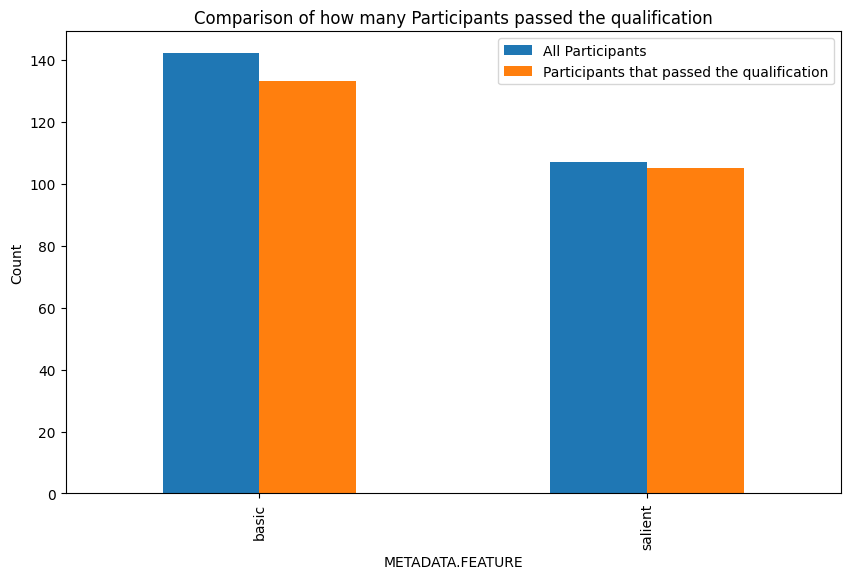

In [113]:
# Get the column data from both dataframes
data_cheater = df_all_versions_cheater["METADATA.FEATURE"]
data_all_versions = df_all_versions["METADATA.FEATURE"]

# Count the occurrences of each unique value in the column
counts_cheater = data_cheater.value_counts()
counts_all_versions = data_all_versions.value_counts()

# Combine the counts into a single dataframe
df_counts = pd.DataFrame({"All Participants": counts_cheater, "Participants that passed the qualification": counts_all_versions})

# Sort the dataframe by the index (unique values in the column)
df_counts.sort_index(inplace=True)

# Plot the data
df_counts.plot(kind="bar", figsize=(10, 6))
plt.xlabel("METADATA.FEATURE")
plt.ylabel("Count")
plt.title("Comparison of how many Participants passed the qualification")
plt.legend()
plt.show()
